In [ ]:
import yfinance as yf
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sqlite3

In [ ]:
apple = yf.Ticker('AAPL').history(interval = '60m', period = '2y', prepost = True)

In [ ]:
apple

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2022-06-27 04:00:00-04:00,141.740000,143.0600,141.740000,142.880000,0,0.0,0.0
2022-06-27 05:00:00-04:00,142.850000,142.9400,142.160000,142.620000,0,0.0,0.0
2022-06-27 06:00:00-04:00,142.580000,142.6400,142.000000,142.100000,0,0.0,0.0
2022-06-27 07:00:00-04:00,142.100000,142.8800,142.020000,142.700000,0,0.0,0.0
2022-06-27 08:00:00-04:00,142.670000,142.9988,141.240000,142.580000,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-06-26 15:30:00-04:00,213.289902,213.5000,212.720001,213.119995,5827438,0.0,0.0
2024-06-26 16:00:00-04:00,213.110000,213.3150,212.830000,213.230000,0,0.0,0.0
2024-06-26 17:00:00-04:00,213.195000,213.2500,212.910000,212.950000,0,0.0,0.0


In [ ]:
import mplfinance as mpf

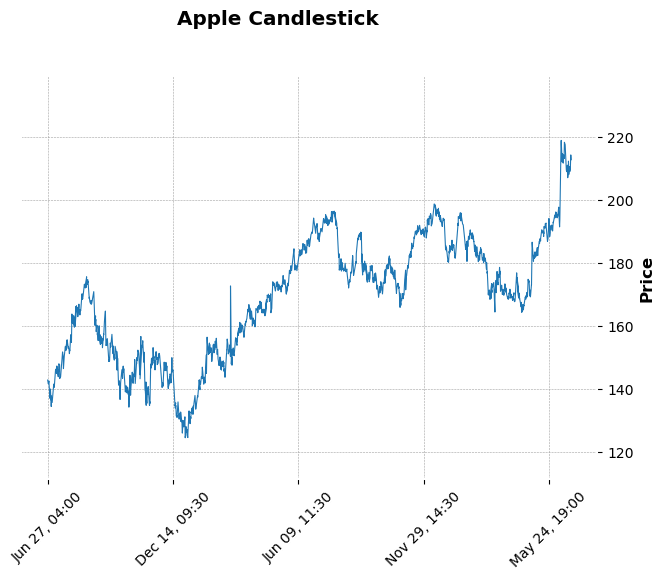

In [ ]:
mpf.plot(apple, type='line', style='charles', title='Apple Candlestick', ylabel='Price')